In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import *

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)


service = QiskitRuntimeService(
    channel='ibm_quantum'
)


In [2]:
#importing pulse related packages

from qiskit import pulse
from qiskit.pulse import ControlChannel, DriveChannel, Play
from qiskit.pulse.library import Drag
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit_ibm_provider import IBMProvider

import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Backend details ##


In [3]:
# Backend details


provider = IBMProvider()
provider.backends()
backend = provider.get_backend('ibm_hanoi')
# service = ExperimentData.get_service_from_backend(backend)

conf = backend.configuration()
defs = backend.defaults()
props = backend.properties()

## Accessing Single qubit gates ##

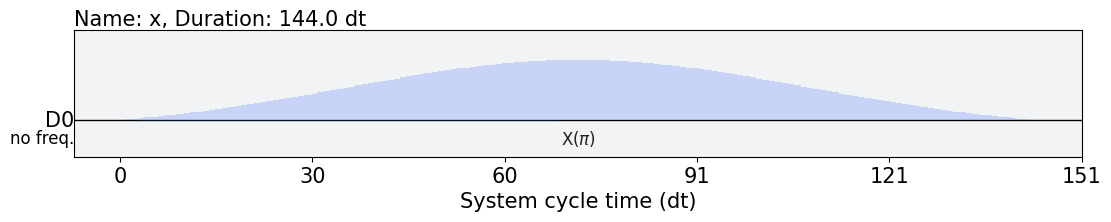

In [25]:
qubit =0
inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
angle = x01_pulse.angle

x01_sched.draw()

In [26]:
qubit = 1

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle
#amp = x01_pulse.amp  ## 0-1 amp for now

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(1)
print(pairs_dict)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')

[{(0, 1): [ControlChannel(0)]}, {(1, 0): [ControlChannel(1)]}, {(1, 2): [ControlChannel(2)]}, {(1, 4): [ControlChannel(3)]}, {(2, 1): [ControlChannel(4)]}, {(4, 1): [ControlChannel(8)]}]
Channels are
  01 Drive: DriveChannel(1)
  12 Drive: ControlChannel(1)
  Cross Res: ControlChannel(0)


In [27]:
freqs01 = [props.frequency(qidx) for qidx in range(conf.num_qubits)]
anharms = [conf.hamiltonian['vars'][f'delta{qidx}']/(2*np.pi) for qidx in range(conf.num_qubits)]
freqs12 = [freqs01[qidx] + anharms[qidx] for qidx in range(conf.num_qubits)]

dt = backend.dt
sqglen_dt= int(props.gate_length('x', qubits=[0])/dt) # all 1Q gates have same length

In [28]:
amp = 2*7.452953e-02
alpha = -3.419883e+08
beta12 = 2.682730e-01

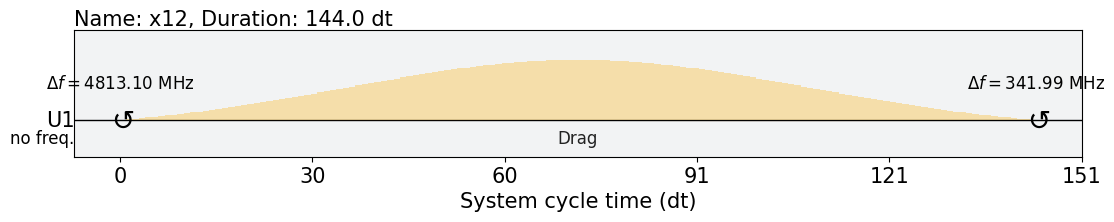

In [29]:
with pulse.build(name='x12') as sched0:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp, 
            angle=angle), 
        chan12)       
        
        pulse.set_frequency(freqs01[qubit], chan12)

sched0.draw()

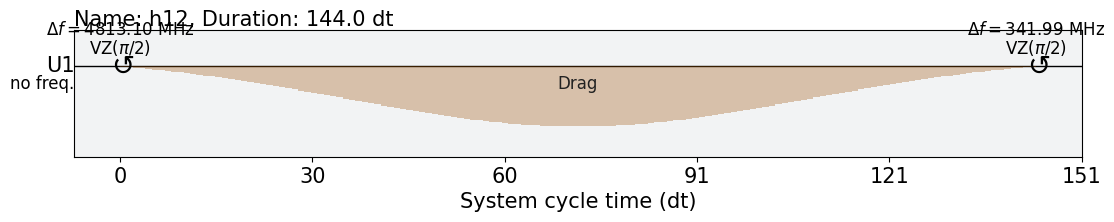

In [30]:
with pulse.build(name='h12') as hsched0:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp/2, 
            angle=angle), 
        chan12)     
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.set_frequency(freqs01[qubit], chan12)
        
hsched0.draw()

In [31]:
amp = 2*8.274180e-02
alpha = -3.394846e+08
beta12 = -1.315730e+00

In [32]:
qubit = 2

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(5)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')
print(pairs_dict)

Channels are
  01 Drive: DriveChannel(2)
  12 Drive: ControlChannel(5)
  Cross Res: ControlChannel(4)
[{(1, 2): [ControlChannel(2)]}, {(2, 1): [ControlChannel(4)]}, {(2, 3): [ControlChannel(5)]}, {(3, 2): [ControlChannel(6)]}]


In [33]:
freqs01 = [props.frequency(qidx) for qidx in range(conf.num_qubits)]
anharms = [conf.hamiltonian['vars'][f'delta{qidx}']/(2*np.pi) for qidx in range(conf.num_qubits)]
freqs12 = [freqs01[qidx] + anharms[qidx] for qidx in range(conf.num_qubits)]

dt = backend.dt
sqglen_dt= int(props.gate_length('x', qubits=[0])/dt) # all 1Q gates have same length


In [34]:
with pulse.build(name='x12') as sched1:
    with pulse.align_sequential():
            pulse.set_frequency(freqs01[qubit]+alpha, chan12)
      
            pulse.play(Drag(
                duration=sqglen_dt, 
                sigma=sigma, 
                beta=beta12, 
                amp=amp, 
                angle=angle), 
            chan12)
        
            pulse.set_frequency(freqs01[qubit], chan12)

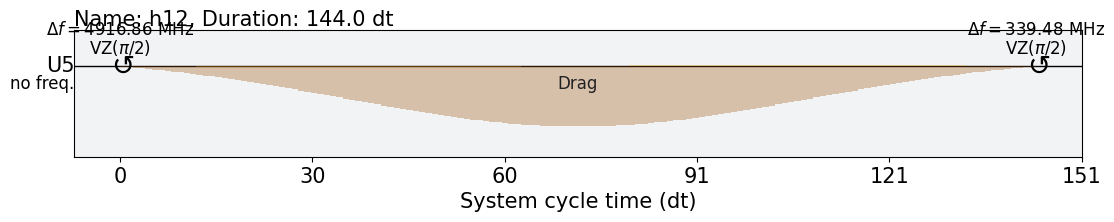

In [35]:
with pulse.build(name='h12') as hsched1:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp/2, 
            angle=angle), 
        chan12)     
        pulse.shift_phase(-np.pi/2,chan12)
        pulse.set_frequency(freqs01[qubit], chan12)
        
hsched1.draw()

In [36]:
from qiskit import QuantumCircuit


qc = QuantumCircuit(1, name='x12')
qc.x(0)
x12 = qc.to_instruction()



qc = QuantumCircuit(1, name='h12')
qc.h(0)
h12 = qc.to_instruction()


In [ ]:
#PHASE SHIFT EXPERIMENT CIRCUITS FOR VARIOUS PERTURBATIONS

In [57]:
def qc0_t(a,b,c,d,e,f,g,h,t_l):
    
#     t = [t_l]
    
#     t = Parameter('$\Theta$')

    qc0 = QuantumCircuit(2,2)

    qc0.u(a,0,c,0)

    qc0.cx(0,1)

    qc0.append(x12,[0])
    qc0.append(x12,[1])

    qc0.sx(0)
    qc0.rz(e,0)
    qc0.sx(0)
    qc0.rz(f,0)

    qc0.cx(0,1)
    qc0.barrier()
    qc0.x(0)
    qc0.append(x12,[0])
    qc0.x(0)
    qc0.barrier()



    qc0.rz(2*np.pi*t_l,1)
    # qc0.assign_parameters([t], inplace=True)
    qc0.barrier()

    qc0.append(h12,[0])
    qc0.x(0)
    qc0.h(1)




    qc0.measure(0,0)
    qc0.measure(1,1)
    qc0.add_calibration("x12", qubits=[1], schedule=sched0)
    qc0.add_calibration("x12", qubits=[2], schedule=sched1)

    qc0.add_calibration("h12", qubits=[1], schedule=hsched0)
    qc0.add_calibration("h12", qubits=[2], schedule=hsched1)


    qc0= transpile(qc0,backend=backend,initial_layout=[1,2])


    return qc0


def qc2_t(a,b,c,d,e,f,g,h,t_l):
    
#     t = [t_l]
    
#     t = Parameter('$\Theta$')
    
    qc2 = QuantumCircuit(2,2)

    qc2.u(a,0,c,0)

    qc2.cx(0,1)

    qc2.append(x12,[0])
    qc2.append(x12,[1])

    qc2.sx(0)
    qc2.rz(e,0)
    qc2.sx(0)
    qc2.rz(f,0)

    qc2.cx(0,1)
    qc2.barrier()

    qc2.x(0)
    qc2.append(x12,[0])
    qc2.x(0)
    qc2.barrier()
    qc2.rz(2*np.pi*t_l,0)
    # qc2.assign_parameters(, inplace=True)
    qc2.barrier()

    qc2.append(h12,[1])
    qc2.x(1)
    qc2.h(0)




    qc2.measure(0,0)
    qc2.measure(1,1)
    qc2.add_calibration("x12", qubits=[1], schedule=sched0)
    qc2.add_calibration("x12", qubits=[2], schedule=sched1)

    qc2.add_calibration("h12", qubits=[1], schedule=hsched0)
    qc2.add_calibration("h12", qubits=[2], schedule=hsched1)


    qc2= transpile(qc2,backend=backend,initial_layout=[1,2])


    return qc2

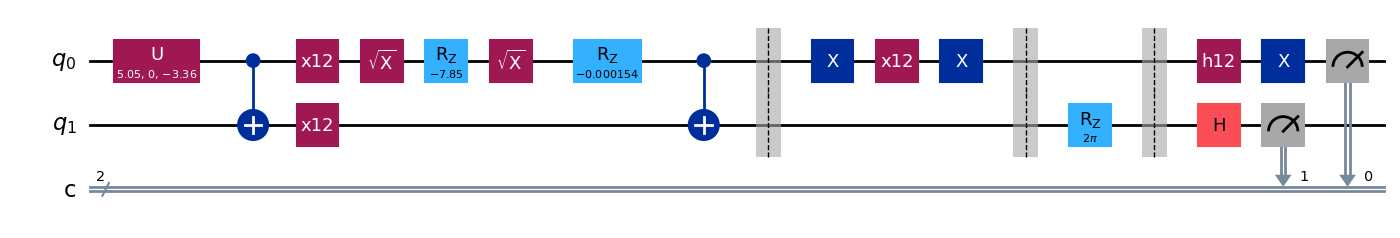

In [54]:
qc0_t(a,b,c,d,e,f,g,h,1).draw()

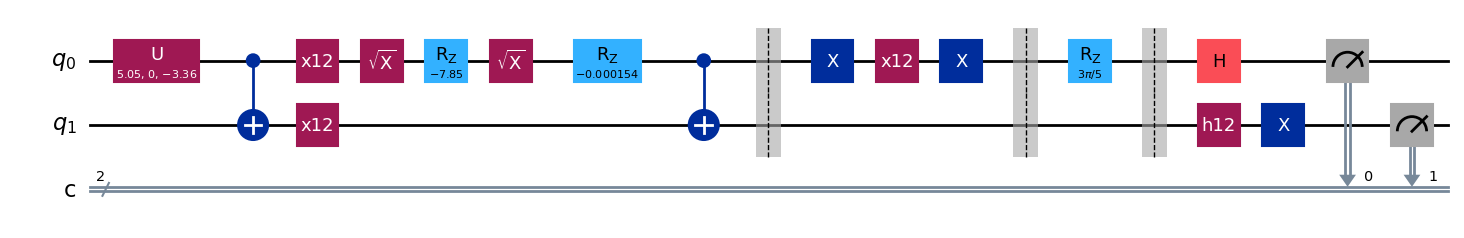

In [56]:
qc2_t(a,b,c,d,e,f,g,h,0.3).draw()

In [58]:
#Phase shift plots, parameters of the PBC ansatz circuit were obtained in a different 

from math import pi
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
service = QiskitRuntimeService()

options = Options(simulator={"seed_simulator": 42},resilience_level=0) 

a0,b0,c0,d0,e0,f0,g0,h0 = np.array([  5.05222826e+00,  0.00000000e+00, -3.35593980e+00,  0.00000000e+00,
        -7.85398332e+00,  1.27772365e-04,  0.00000000e+00,  0.00000000e+00   ]) ###h(0)
a1,b1,c1,d1,e1,f1,g1,h1 = np.array([ 4.82472468,  0.        ,  0.51284202,  0.        , -2.21030367,
        -1.04719757,  0.        ,  0.     ]) ###h(2*pi/3)
a2,b2,c2,d2,e2,f2,g2,h2 = np.array([ 1.36846073,  0.        , -1.95390752,  0.        , -1.90781497,
        -0.78539817,  0.        ,  0.   ]) ###h(pi/2)                          
a3,b3,c3,d3,e3,f3,g3,h3 = np.array([  1.32091634,  0.        , -1.57547149,  0.        , -1.77926162,
        -0.62831853,  0.        ,  0.      ]) ###h(2*pi/5)
a4,b4,c4,d4,e4,f4,g4,h4 = np.array([ 1.29400965,  0.        , -1.33280211,  0.        , -1.71280047,
        -0.52359911,  0.        ,  0.  ]) ###h(2*pi/6)
a5,b5,c5,d5,e5,f5,g5,h5 = np.array([1.27750049,  0.        , -1.16375118,  0.        , -1.67389836,
        -0.44879916,  0.        ,  0.       ]) ###h(2*pi/7)
a6,b6,c6,d6,e6,f6,g6,h6 = np.array([1.45846064,  0.        ,  1.56003955,  0.        , -2.21030365,
         1.04719752,  0.        ,  0.    ]) ###h(4*pi/3)
a7,b7,c7,d7,e7,f7,g7,h7 = np.array([4.7585407 ,  0.        , -0.07014538,  0.        , -2.53852046,
        -1.25663707,  0.        ,  0.     ]) ###h(4*pi/5)

a8,b8,c8,d8,e8,f8,g8,h8 = np.array([1.40627187,  0.        , -2.23596492,  0.        , -2.02313077,
        -0.89759794,  0.        ,  0.   ]) ###h(4*pi/7)

a9,b9,c9,d9,e9,f9,g9,h9 = np.array([1.36846078,  0.        ,  1.18768511,  0.        , -8.19100026,
         0.78539812,  0.        ,  0.    ]) ###h(3pi/2)

a10,b10,c10,d10,e10,f10,g10,h10 = np.array([-1.52464461,  0.        , -1.92985465,  0.        , -3.74466487,
        -1.88495561,  0.        ,  0 ]) ###h(6pi/5)


a11,b11,c11,d11,e11,f11,g11,h11 = np.array([20.39586053,  0.        ,  2.36996094,  0.        , -3.58245397,
         1.79519579,  0.        ,  0.  ]) ###h(6pi/7)

a12,b12,c12,d12,e12,f12,g12,H12 = np.array([1.29400921,  0.        ,  0.76159287,  0.        , -1.71280072,
         0.52359845,  0.        ,  0.       ]) ###h(10pi/6)

a13,b13,c13,d13,e13,f13,g13,h13 = np.array([-4.73688071,  0.        ,  1.91322434,  0.        , -2.70073136,
         1.34639684,  0.        ,  0.  ]) ###h(8pi/7)

a14,b14,c14,d14,e14,f14,g14,h14 = np.array([  1.40627189,  0.        ,  1.35442674,  0.        , -2.02313076,
         0.89759789,  0.        ,  0.       ]) ###h(10pi/7)
a15,b15,c15,d15,e15,f15,g15,h15 = np.array([1.27750021, 0.        , 0.63144367, 0.        , 4.60928666,
        0.44879832, 0.        , 0.  ]) ###h(12pi/7)







qc0_0_t = [qc0_t(a0,b0,c0,d0,e0,f0,g0,h0,t0)  for t0 in np.linspace(0,1,100)]
qc1_0_t = [qc2_t(a0,b0,c0,d0,e0,f0,g0,h0,t0) for t0 in np.linspace(0,1,100)]
####
qc0_1_t = [qc0_t(a1,b1,c1,d1,e1,f1,g1,h1,t0)  for t0 in np.linspace(0,1,100)]
qc1_1_t = [qc2_t(a1,b1,c1,d1,e1,f1,g1,h1,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_2_t = [qc0_t(a2,b2,c2,d2,e2,f2,g2,h2,t0)  for t0 in np.linspace(0,1,100)]
qc1_2_t = [qc2_t(a2,b2,c2,d2,e2,f2,g2,h2,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_3_t = [qc0_t(a3,b3,c3,d3,e3,f3,g3,h3,t0)  for t0 in np.linspace(0,1,100)]
qc1_3_t = [qc2_t(a3,b3,c3,d3,e3,f3,g3,h3,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_4_t = [qc0_t(a4,b4,c4,d4,e4,f4,g4,h4,t0)  for t0 in np.linspace(0,1,100)]
qc1_4_t = [qc2_t(a4,b4,c4,d4,e4,f4,g4,h4,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_5_t = [qc0_t(a5,b5,c5,d5,e5,f5,g5,h5,t0)  for t0 in np.linspace(0,1,100)]
qc1_5_t = [qc2_t(a5,b5,c5,d5,e5,f5,g5,h5,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_6_t = [qc0_t(a6,b6,c6,d6,e6,f6,g6,h6,t0)  for t0 in np.linspace(0,1,100)]
qc1_6_t = [qc2_t(a6,b6,c6,d6,e6,f6,g6,h6,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_7_t = [qc0_t(a7,b7,c7,d7,e7,f7,g7,h7,t0)  for t0 in np.linspace(0,1,100)]
qc1_7_t = [qc2_t(a7,b7,c7,d7,e7,f7,g7,h7,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_8_t = [qc0_t(a8,b8,c8,d8,e8,f8,g8,h8,t0)  for t0 in np.linspace(0,1,100)]
qc1_8_t = [qc2_t(a8,b8,c8,d8,e8,f8,g8,h8,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_9_t = [qc0_t(a9,b9,c9,d9,e9,f9,g9,h9,t0)  for t0 in np.linspace(0,1,100)]
qc1_9_t = [qc2_t(a9,b9,c9,d9,e9,f9,g9,h9,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_10_t = [qc0_t(a10,b10,c10,d10,e10,f10,g10,h10,t0)  for t0 in np.linspace(0,1,100)]
qc1_10_t = [qc2_t(a10,b10,c10,d10,e10,f10,g10,h10,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_11_t = [qc0_t(a11,b11,c11,d11,e11,f11,g11,h11,t0)  for t0 in np.linspace(0,1,100)]
qc1_11_t = [qc2_t(a11,b11,c11,d11,e11,f11,g11,h11,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_12_t = [qc0_t(a12,b12,c12,d12,e12,f12,g12,H12,t0)  for t0 in np.linspace(0,1,100)]
qc1_12_t = [qc2_t(a12,b12,c12,d12,e12,f12,g12,H12,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_13_t = [qc0_t(a13,b13,c13,d13,e13,f13,g13,h13,t0)  for t0 in np.linspace(0,1,100)]
qc1_13_t = [qc2_t(a13,b13,c13,d13,e13,f13,g13,h13,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_14_t = [qc0_t(a14,b14,c14,d14,e14,f14,g14,h14,t0)  for t0 in np.linspace(0,1,100)]
qc1_14_t = [qc2_t(a14,b14,c14,d14,e14,f14,g14,h14,t0)  for t0 in np.linspace(0,1,100)]
####
qc0_15_t = [qc0_t(a15,b15,c15,d15,e15,f15,g15,h15,t0)  for t0 in np.linspace(0,1,100)]
qc1_15_t = [qc2_t(a15,b15,c15,d15,e15,f15,g15,h15,t0)  for t0 in np.linspace(0,1,100)]
####



qiskit_runtime_service.__init__:INFO:2024-04-10 06:43:17,924: Default instance: ibm-q-ornl/ornl/cph140


In [59]:
with Session(service=service, backend='ibm_hanoi'):
    sampler = Sampler() # Define sampler with options above
    job0 = sampler.run(circuits=qc0_0_t,skip_transpilation=True, shots =10**3) # build your code here
    print("First job:", job0.job_id())
    job1 = sampler.run(circuits=qc1_0_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Second job:",job1.job_id())
    job2 = sampler.run(circuits=qc0_1_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Third job:",job2.job_id())
    job3 = sampler.run(circuits=qc1_1_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Fourth job:",job3.job_id())
    job4 = sampler.run(circuits=qc0_2_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Fifth job:",job4.job_id())
    job5 = sampler.run(circuits=qc1_2_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Sixth job:",job5.job_id())
    job6 = sampler.run(circuits=qc0_3_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Seventh job:",job6.job_id())
    job7 = sampler.run(circuits=qc1_3_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Eigth job:",job7.job_id())
    job8 = sampler.run(circuits=qc0_4_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Ninth job:",job8.job_id())
    job9 = sampler.run(circuits=qc1_4_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Tenth job:",job9.job_id())
    job10 = sampler.run(circuits=qc0_5_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Eleventh job:",job10.job_id())
    job11 = sampler.run(circuits=qc1_5_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Twelfth job:",job11.job_id())
    job12 = sampler.run(circuits=qc0_6_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Thirteenth job:",job12.job_id())
    job13 = sampler.run(circuits=qc1_6_t,skip_transpilation=True, shots =10**3) # build your code here
    print("Fourteenth job:",job13.job_id())
    job14 = sampler.run(circuits=qc0_7_t,skip_transpilation=True, shots =10**3) # build your code here
    print("15job:", job14.job_id())
    job15 = sampler.run(circuits=qc1_7_t,skip_transpilation=True, shots =10**3) # build your code here
    print("16job:",job15.job_id())
    job16 = sampler.run(circuits=qc0_8_t,skip_transpilation=True, shots =10**3) # build your code here
    print("17job:",job16.job_id())
    job17 = sampler.run(circuits=qc1_8_t,skip_transpilation=True, shots =10**3) # build your code here
    print("18job:",job17.job_id())
    job18 = sampler.run(circuits=qc0_9_t,skip_transpilation=True, shots =10**3) # build your code here
    print("19job:",job18.job_id())
    job19 = sampler.run(circuits=qc1_9_t,skip_transpilation=True, shots =10**3) # build your code here
    print("20job:",job19.job_id())
    job20 = sampler.run(circuits=qc0_10_t,skip_transpilation=True, shots =10**3) # build your code here
    print("21job:",job20.job_id())
    job21 = sampler.run(circuits=qc1_10_t,skip_transpilation=True, shots =10**3) # build your code here
    print("22job:",job21.job_id())
    job22 = sampler.run(circuits=qc0_11_t,skip_transpilation=True, shots =10**3) # build your code here
    print("23job:",job22.job_id())
    job23 = sampler.run(circuits=qc1_11_t,skip_transpilation=True, shots =10**3) # build your code here
    print("24job:",job23.job_id())
    job24 = sampler.run(circuits=qc0_12_t,skip_transpilation=True, shots =10**3) # build your code here
    print("25job:",job24.job_id())
    job25 = sampler.run(circuits=qc1_12_t,skip_transpilation=True, shots =10**3) # build your code here
    print("26job:",job25.job_id())
    job26 = sampler.run(circuits=qc0_13_t,skip_transpilation=True, shots =10**3) # build your code here
    print("27job:",job26.job_id())
    job27 = sampler.run(circuits=qc1_13_t,skip_transpilation=True, shots =10**3) # build your code here
    print("28job:",job27.job_id())
    job28 = sampler.run(circuits=qc0_14_t,skip_transpilation=True, shots =10**3) # build your code here
    print("29job:",job28.job_id())
    job29 = sampler.run(circuits=qc1_14_t,skip_transpilation=True, shots =10**3) # build your code here
    print("30job:",job29.job_id())
    job30 = sampler.run(circuits=qc0_15_t,skip_transpilation=True, shots =10**3) # build your code here
    print("31job:",job30.job_id())
    job31 = sampler.run(circuits=qc1_15_t,skip_transpilation=True, shots =10**3) # build your code here
    print("32job:",job31.job_id())
    

base_primitive._run_primitive:INFO:2024-04-10 06:45:39,347: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
base_primitive._run_primitive:INFO:2024-04-10 06:45:43,120: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


First job: crb3b5mbs5wg008anxjg


base_primitive._run_primitive:INFO:2024-04-10 06:45:46,553: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Second job: crb3b6m78n6g008dxk2g


base_primitive._run_primitive:INFO:2024-04-10 06:45:49,632: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Third job: crb3b7c622j0008m6y3g


base_primitive._run_primitive:INFO:2024-04-10 06:45:52,798: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Fourth job: crb3b85622j0008m6y40


base_primitive._run_primitive:INFO:2024-04-10 06:45:55,720: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Fifth job: crb3b8x622j0008m6y4g


base_primitive._run_primitive:INFO:2024-04-10 06:45:58,987: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Sixth job: crb3b9ndjmqg008kcgn0


base_primitive._run_primitive:INFO:2024-04-10 06:46:02,467: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Seventh job: crb3bandjmqg008kcgng


base_primitive._run_primitive:INFO:2024-04-10 06:46:06,261: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Eigth job: crb3bbdhjs5g008pxnwg


base_primitive._run_primitive:INFO:2024-04-10 06:46:09,975: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Ninth job: crb3bcd622j0008m6y50


base_primitive._run_primitive:INFO:2024-04-10 06:46:13,084: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Tenth job: crb3bd5dqdn0008322eg


base_primitive._run_primitive:INFO:2024-04-10 06:46:16,390: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Eleventh job: crb3bdxdqdn0008322f0


base_primitive._run_primitive:INFO:2024-04-10 06:46:19,504: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Twelfth job: crb3bexbs5wg008anxm0


base_primitive._run_primitive:INFO:2024-04-10 06:46:22,903: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Thirteenth job: crb3bfn78n6g008dxk30


base_primitive._run_primitive:INFO:2024-04-10 06:46:26,278: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Fourteenth job: crb3bgedqdn0008322fg


base_primitive._run_primitive:INFO:2024-04-10 06:46:29,729: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


15job: crb3bhedqdn0008322g0


base_primitive._run_primitive:INFO:2024-04-10 06:46:32,713: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


16job: crb3bj6dqdn0008322gg


base_primitive._run_primitive:INFO:2024-04-10 06:46:36,175: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


17job: crb3bjydqdn0008322h0


base_primitive._run_primitive:INFO:2024-04-10 06:46:39,277: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


18job: crb3bkp622j0008m6y60


base_primitive._run_primitive:INFO:2024-04-10 06:46:42,348: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


19job: crb3bmedqdn0008322hg


base_primitive._run_primitive:INFO:2024-04-10 06:46:45,893: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


20job: crb3bnehjs5g008pxnx0


base_primitive._run_primitive:INFO:2024-04-10 06:46:48,866: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


21job: crb3bp6hjs5g008pxnxg


base_primitive._run_primitive:INFO:2024-04-10 06:46:52,067: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


22job: crb3bpydqdn0008322j0


base_primitive._run_primitive:INFO:2024-04-10 06:46:55,122: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


23job: crb3bqp78n6g008dxk4g


base_primitive._run_primitive:INFO:2024-04-10 06:46:58,237: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


24job: crb3brf622j0008m6y6g


base_primitive._run_primitive:INFO:2024-04-10 06:47:01,461: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


25job: crb3bsfdqdn0008322jg


base_primitive._run_primitive:INFO:2024-04-10 06:47:04,500: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


26job: crb3bt7dqdn0008322k0


base_primitive._run_primitive:INFO:2024-04-10 06:47:07,463: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


27job: crb3btq622j0008m6y80


base_primitive._run_primitive:INFO:2024-04-10 06:47:11,005: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


28job: crb3bvqdjmqg008kcgpg


base_primitive._run_primitive:INFO:2024-04-10 06:47:14,267: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


29job: crb3bwfdqdn0008322kg


base_primitive._run_primitive:INFO:2024-04-10 06:47:17,055: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


30job: crb3bx7djmqg008kcgq0


base_primitive._run_primitive:INFO:2024-04-10 06:47:20,161: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


31job: crb3bxzhjs5g008pxny0
32job: crb3byqdjmqg008kcgqg


In [4]:
# #JOB-IDS for phase shift plots


J_list = ['crb3b5mbs5wg008anxjg',
'crb3b6m78n6g008dxk2g',
'crb3b7c622j0008m6y3g',
'crb3b85622j0008m6y40',
'crb3b8x622j0008m6y4g',
'crb3b9ndjmqg008kcgn0',
'crb3bandjmqg008kcgng',
'crb3bbdhjs5g008pxnwg',
'crb3bcd622j0008m6y50',
'crb3bd5dqdn0008322eg',
'crb3bdxdqdn0008322f0',
'crb3bexbs5wg008anxm0',
'crb3bfn78n6g008dxk30',
'crb3bgedqdn0008322fg',
'crb3bhedqdn0008322g0',
'crb3bj6dqdn0008322gg',
'crb3bjydqdn0008322h0',
'crb3bkp622j0008m6y60',
'crb3bmedqdn0008322hg',
'crb3bnehjs5g008pxnx0',
'crb3bp6hjs5g008pxnxg',
'crb3bpydqdn0008322j0',
'crb3bqp78n6g008dxk4g',
'crb3brf622j0008m6y6g',
'crb3bsfdqdn0008322jg',
'crb3bt7dqdn0008322k0',
'crb3btq622j0008m6y80',
'crb3bvqdjmqg008kcgpg',
'crb3bwfdqdn0008322kg',
'crb3bx7djmqg008kcgq0',
'crb3bxzhjs5g008pxny0',
'crb3byqdjmqg008kcgqg']


In [ ]:
#Fit function

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sinusoidal function
def sinusoidal_func(x, A, f, phi, offset):
    return A * np.cos(f * x + phi) + offset



# Fit the data to the sinusoidal function
initial_guess = (1, 1, np.pi/4, 0)  # initial guess for the parameters (A, f, phi, offset)

qiskit_runtime_service.__init__:INFO:2024-04-16 16:50:51,406: Default instance: ibm-q-ornl/ornl/cph140


Phase: 0.5646471623254434
Relative error%: 0.03925627718290726
Range = 0.34206765726189653


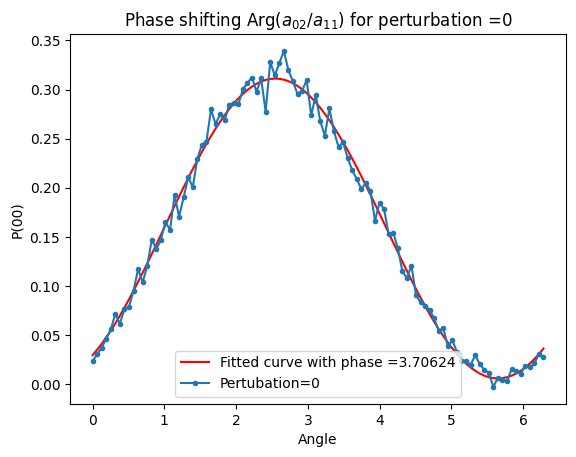

Phase: -0.41488719475127495
Relative error%: -0.13031461460268498
Range = 0.2391183997996906


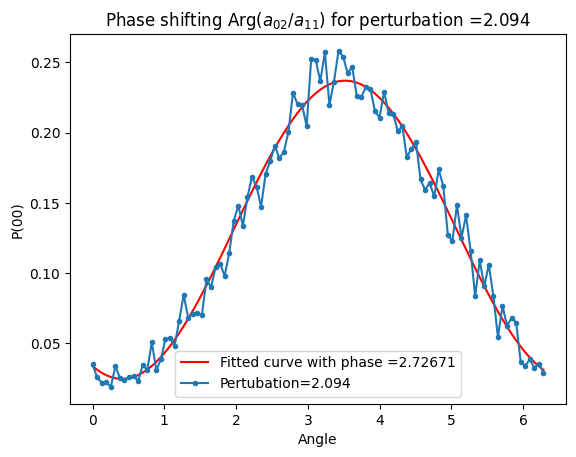

Phase: -0.11637023883736361
Relative error%: -0.438451668120719
Range = 0.2857983744598007


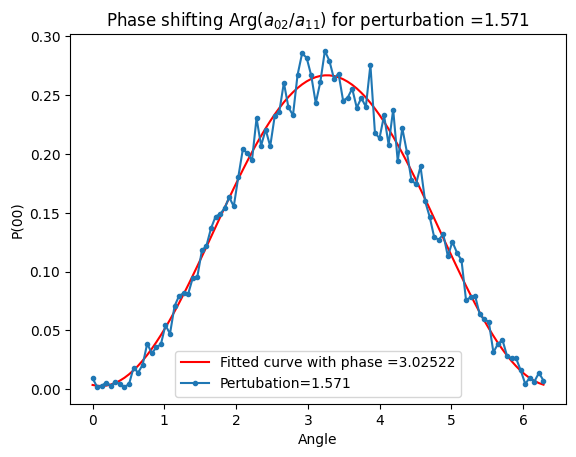

Phase: 0.060523269430365886
Relative error%: 0.8186198973150476
Range = 0.31570055266195773


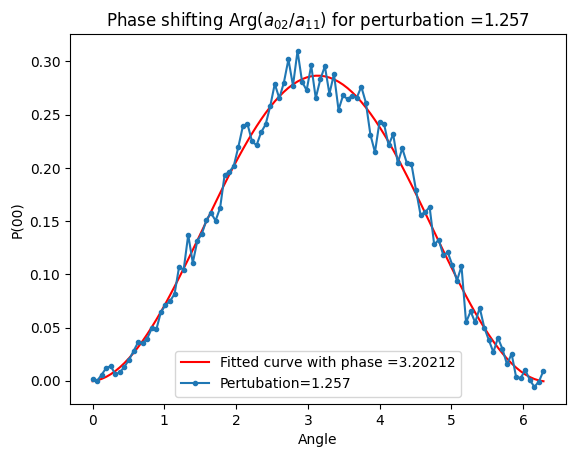

Phase: 0.08350865112897561
Relative error%: 0.4607805057434852
Range = 0.29668624894120765


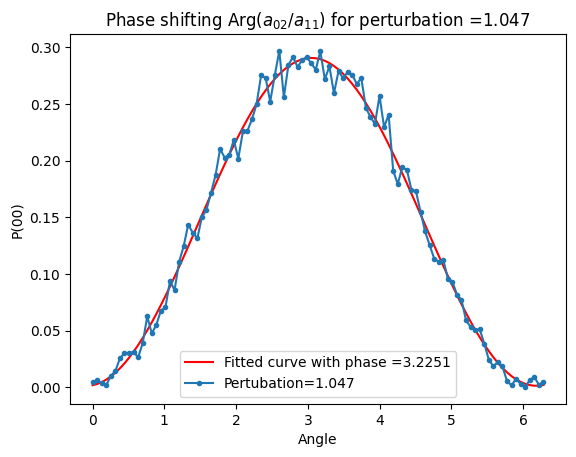

Phase: 0.19408940977218633
Relative error%: 0.19016016832417407
Range = 0.3265677616873197


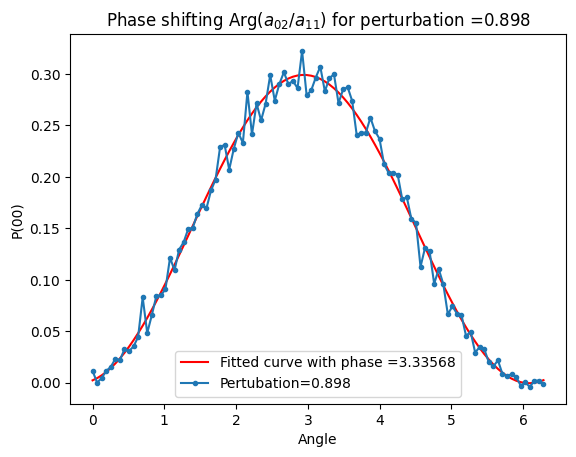

Phase: 1.7493477265733586
Relative error%: 0.018205799034692622
Range = 0.20740447379707858


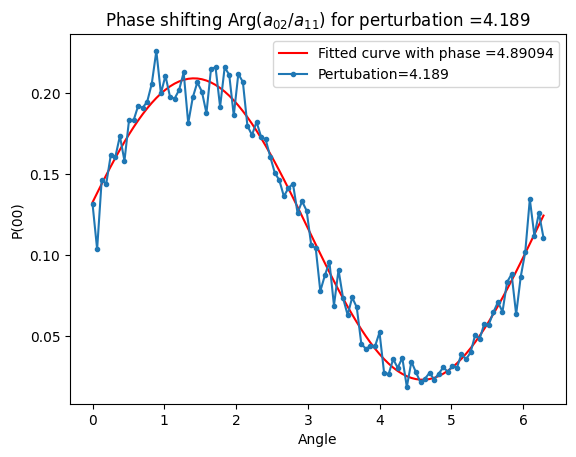

Phase: -0.5630514903183984
Relative error%: -0.1175545670373518
Range = 0.16610530986818


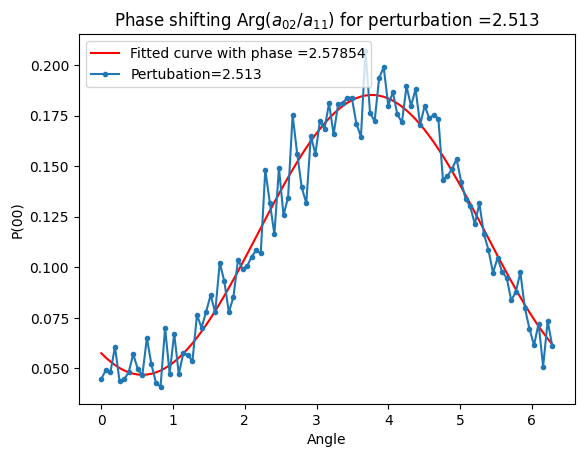

Phase: -0.21503748950395898
Relative error%: -0.25532983974397067
Range = 0.28118777789644506


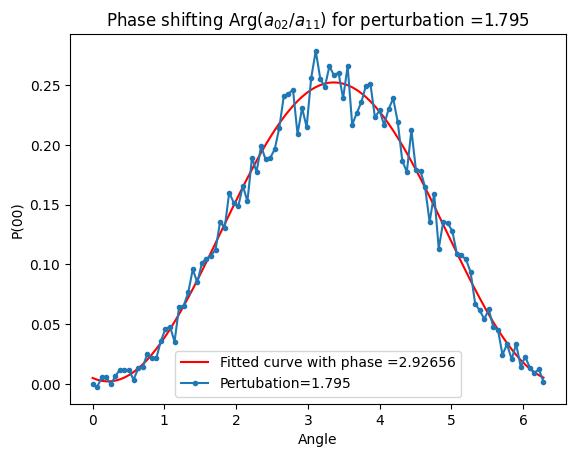

Phase: 1.4349515044671615
Relative error%: 0.018204343283360992
Range = 0.2987774074778836


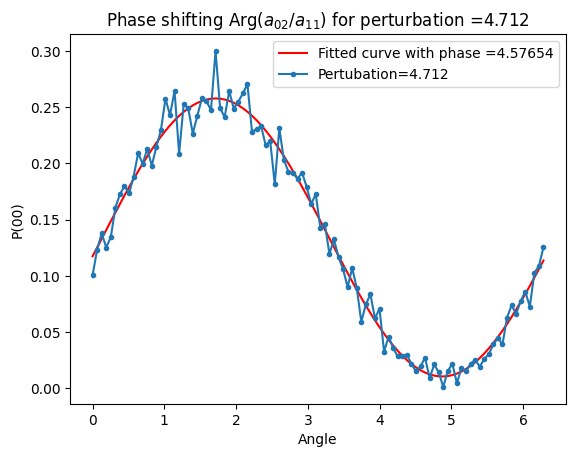

Phase: 1.93047126169831
Relative error%: 0.024028662576462915
Range = 0.15784625144630532


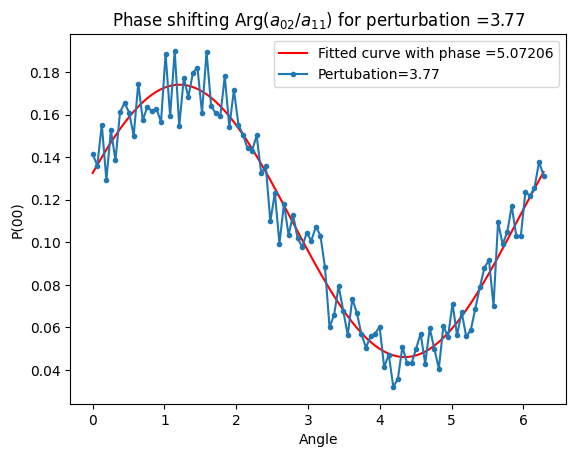

Phase: -0.6377253957706976
Relative error%: -0.12593147466075433
Range = 0.1407459111747129


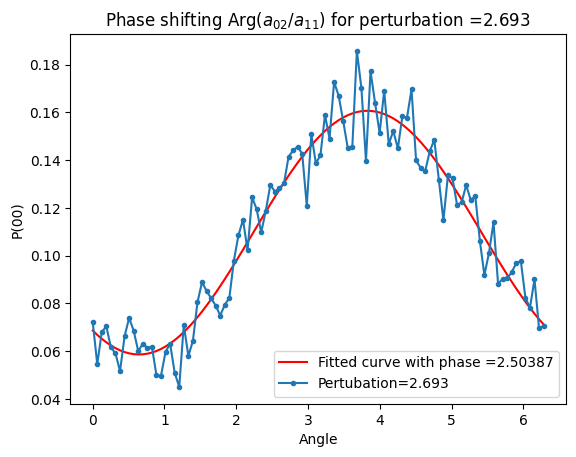

Phase: 1.1228264981245302
Relative error%: 0.022481884303342033
Range = 0.2944510370445921


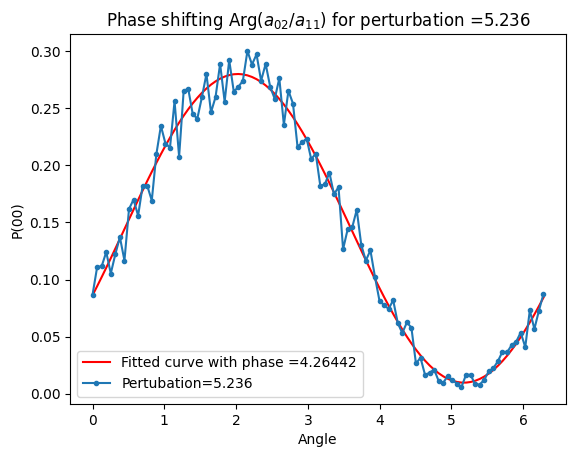

Phase: 2.025481098318307
Relative error%: 0.03394318923547096
Range = 0.12516024558643707


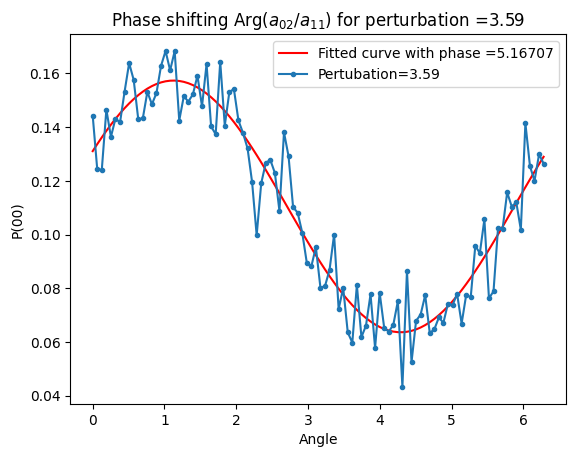

Phase: 1.528097925612769
Relative error%: 0.017626472501678436
Range = 0.24488012438915557


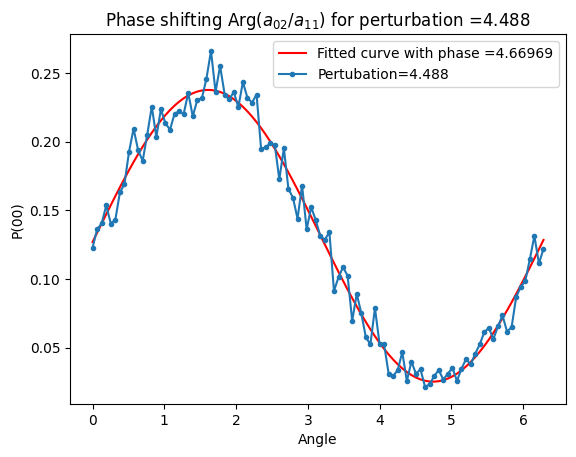

Phase: 1.072960447789009
Relative error%: 0.022235437061808878
Range = 0.322507279811835


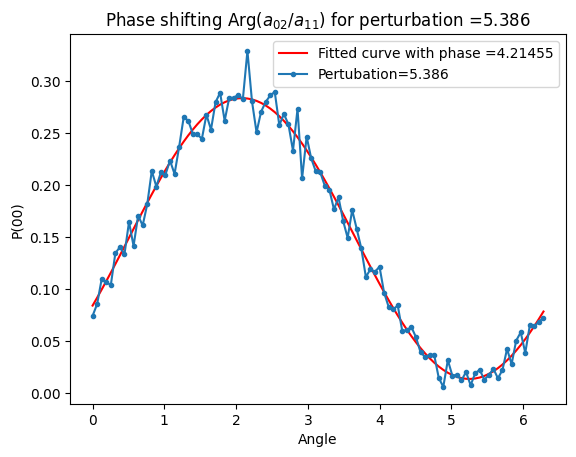

In [17]:
from math import pi
import cmath
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
import matplotlib.pyplot as plt
service = QiskitRuntimeService()



pert = [0,2*np.pi/3,np.pi/2,2*np.pi/5,2*np.pi/6,2*np.pi/7,4*np.pi/3,4*np.pi/5,4*np.pi/7,3*np.pi/2,6*np.pi/5,6*np.pi/7,10*np.pi/6,8*np.pi/7,10*np.pi/7,12*np.pi/7]

for j in range(16):

  job = service.job(J_list[2*j])

  Result = job.result()


  R = [Result.quasi_dists[i][0] for i in range(100)]

  popt, pcov = curve_fit(sinusoidal_func, np.linspace(0,2*np.pi,100), R, p0=initial_guess)

  plt.plot(np.linspace(0,2*np.pi,100), sinusoidal_func(np.linspace(0,2*np.pi,100), *popt), 'r-', label='Fitted curve with phase =' + str(np.round(cmath.phase(popt[0])+popt[2],5)))

  
  print("Phase:", popt[2])
  
  print("Relative error%:",np.sqrt(np.diag(pcov))[2]/popt[2])

  print("Range =",max(R)-min(R))
  plt.plot(np.linspace(0,2*np.pi,100),R, ".-",label = "Pertubation="+str(np.round(pert[j],3)))
  plt.xlabel("Angle")
  plt.ylabel("P(00)")
  plt.legend()
  plt.title("Phase shifting Arg($a_{02}/a_{11})$ for perturbation ="+str(np.round(pert[j],3)))
  plt.savefig("BP_qc0_t"+str(j)+".png")
  plt.show()

qiskit_runtime_service.__init__:INFO:2024-04-16 16:56:03,931: Default instance: ibm-q-ornl/ornl/cph140


Phase: 1.8680793223424184
Relative error%: 0.021796531560530994
Range = 0.19955222173510312


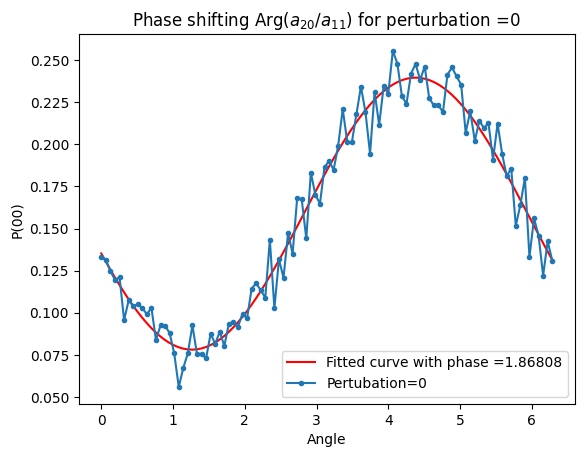

Phase: 1.8408089520588977
Relative error%: 0.022052774000790382
Range = 0.16787101832382756


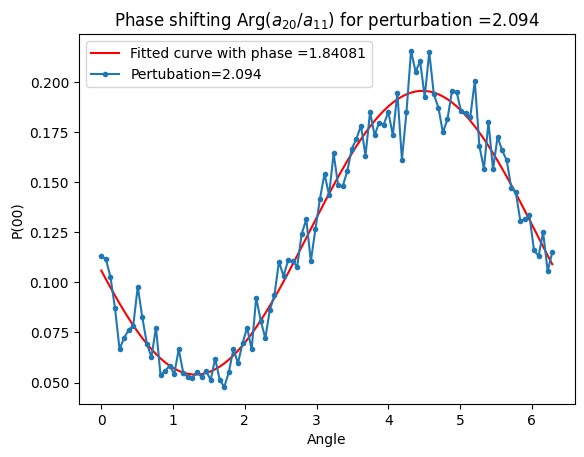

Phase: 1.2194035593227122
Relative error%: 0.045493254452835793
Range = 0.16509146876671438


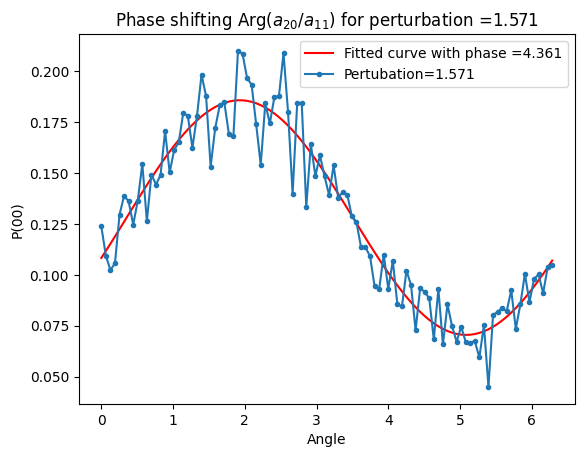

Phase: 1.2902695936005892
Relative error%: 0.043096800263797405
Range = 0.1521189471570063


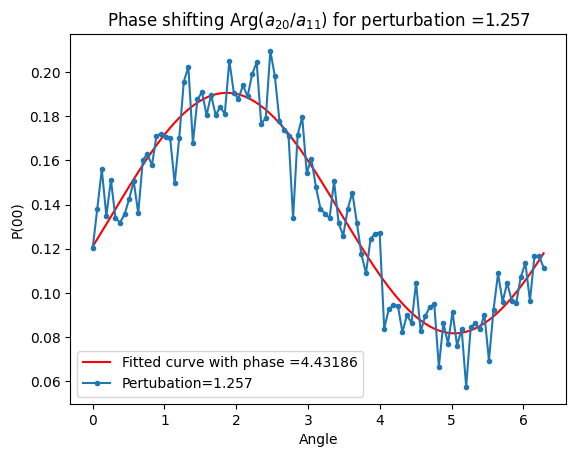

Phase: 1.2477878721206712
Relative error%: 0.04043348413999573
Range = 0.15338038077003716


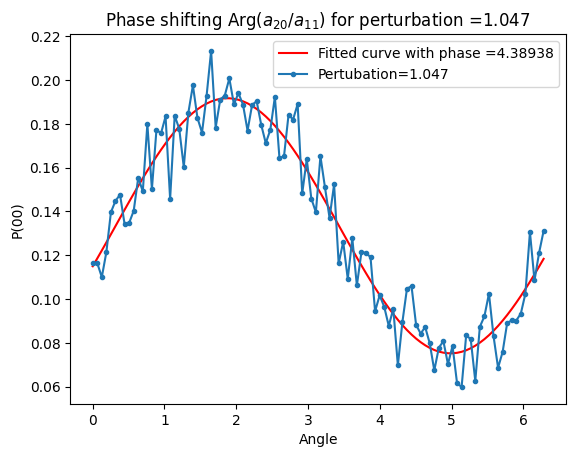

Phase: 1.2481228469645558
Relative error%: 0.03819440109018164
Range = 0.15526990019454762


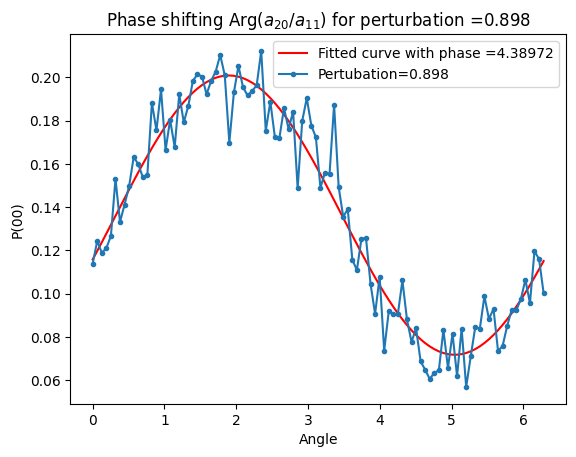

Phase: 1.411217100424367
Relative error%: 0.06393545591367458
Range = 0.11050235819673954


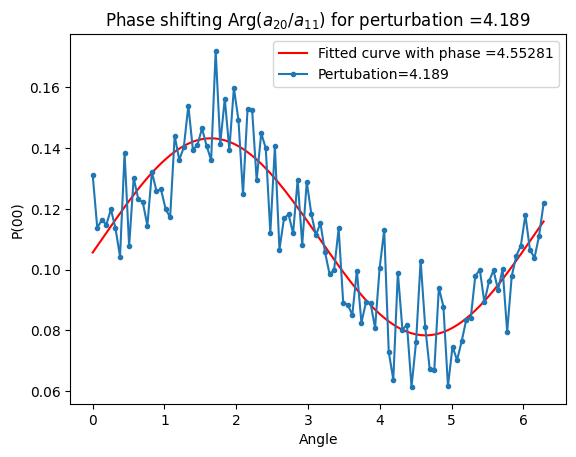

Phase: 2.223270636131424
Relative error%: 0.02809067702152334
Range = 0.16314384755390485


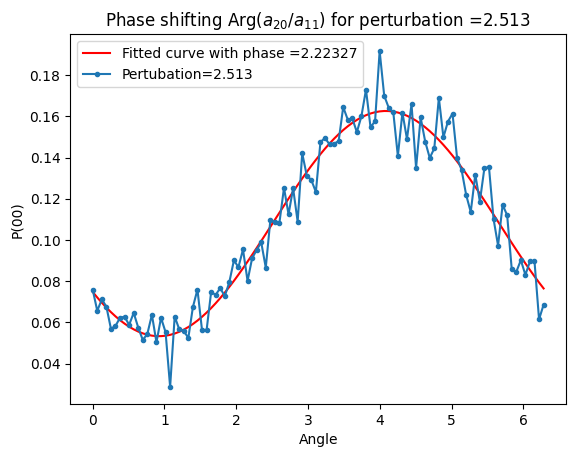

Phase: 1.349840452680987
Relative error%: 0.040078028776648275
Range = 0.1360766703937893


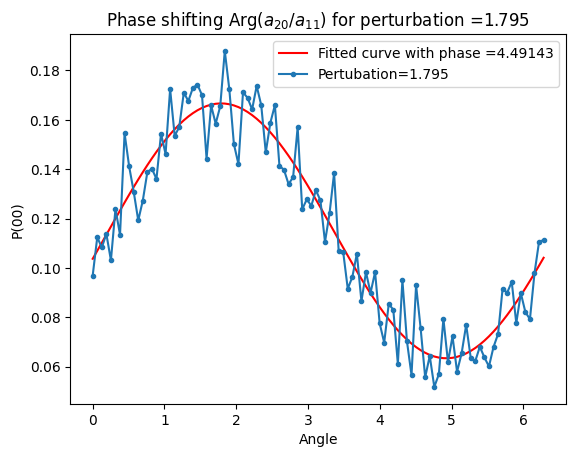

Phase: 1.2600917693821942
Relative error%: 0.029588614277942675
Range = 0.17161147791970677


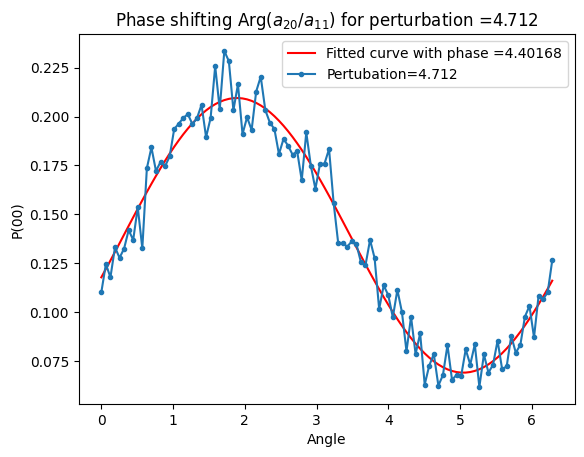

Phase: 2.252057636223913
Relative error%: 0.039477285289321304
Range = 0.1136189461565558


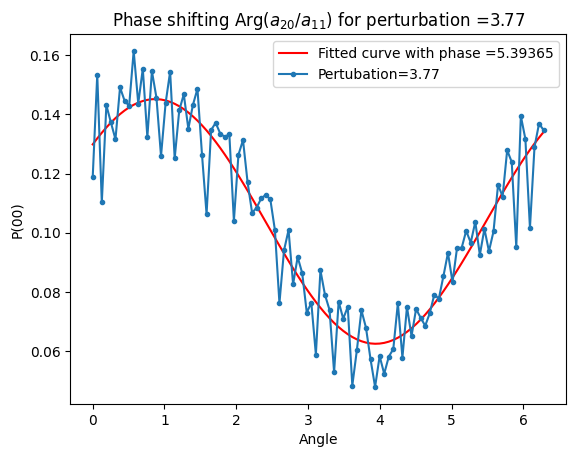

Phase: 0.12733922692361474
Relative error%: 1.9287455637599176
Range = 0.09210897186713868


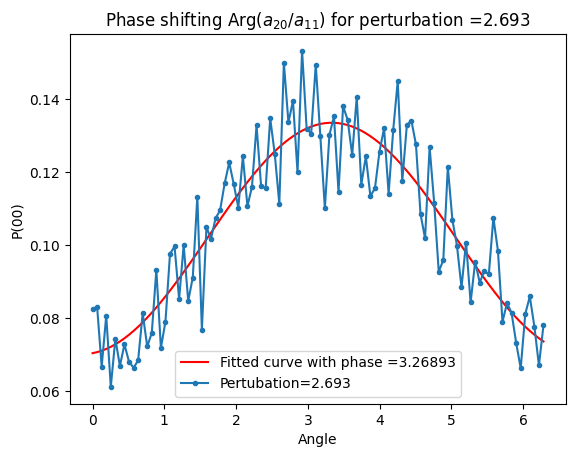

Phase: 1.119874705611117
Relative error%: 0.06299420887635371
Range = 0.11775703217556807


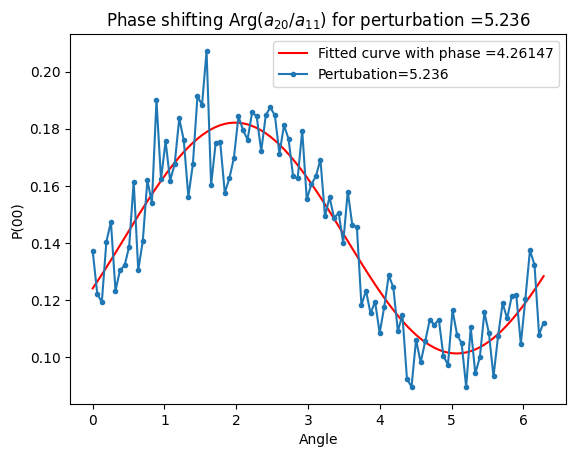

Phase: 1.0244940531728723
Relative error%: 0.19999240647133457
Range = 0.06827101334182338


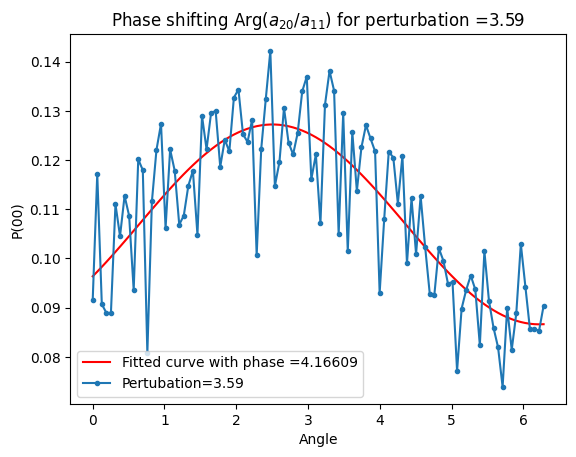

Phase: 1.590174426485194
Relative error%: 0.02798304619597677
Range = 0.1736338495086932


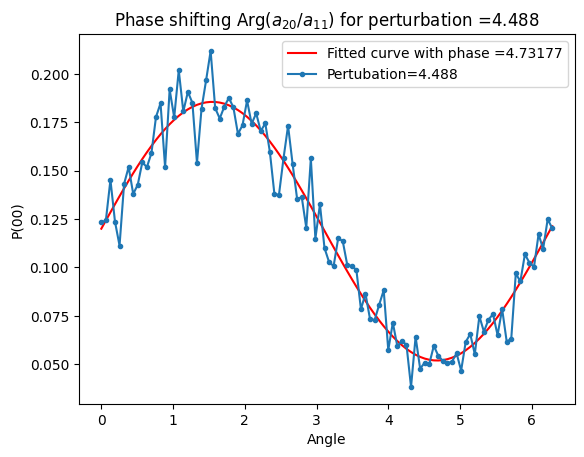

Phase: 1.4388944374335964
Relative error%: 0.02359795768397231
Range = 0.20304851811201632


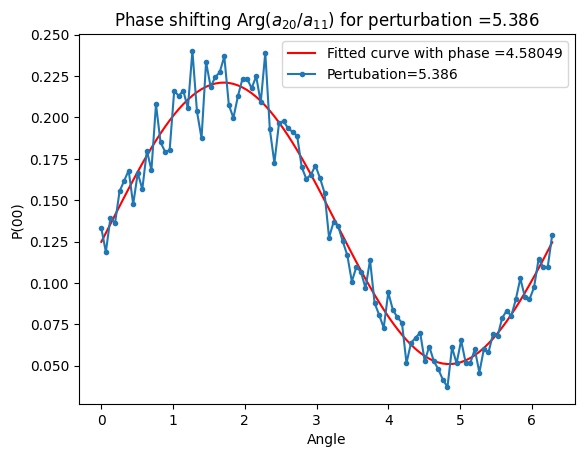

In [18]:
from math import pi
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
import matplotlib.pyplot as plt
service = QiskitRuntimeService()



pert = [0,2*np.pi/3,np.pi/2,2*np.pi/5,2*np.pi/6,2*np.pi/7,4*np.pi/3,4*np.pi/5,4*np.pi/7,3*np.pi/2,6*np.pi/5,6*np.pi/7,10*np.pi/6,8*np.pi/7,10*np.pi/7,12*np.pi/7]

for j in range(16):

  job = service.job(J_list[2*j+1])

  Result = job.result()


  R = [Result.quasi_dists[i][0] for i in range(100)]
  
  popt, pcov = curve_fit(sinusoidal_func, np.linspace(0,2*np.pi,100), R, p0=initial_guess)

  plt.plot(np.linspace(0,2*np.pi,100), sinusoidal_func(np.linspace(0,2*np.pi,100), *popt), 'r-', label='Fitted curve with phase =' + str(np.round(cmath.phase(popt[0])+popt[2],5)))

  
  print("Phase:", popt[2])
  
  print("Relative error%:",np.sqrt(np.diag(pcov))[2]/popt[2])
  print("Range =",max(R)-min(R))
  plt.plot(np.linspace(0,2*np.pi,100),R, ".-",label = "Pertubation="+str(np.round(pert[j],3)))
  plt.xlabel("Angle")
  plt.ylabel("P(00)")
  plt.legend()
  plt.title("Phase shifting Arg($a_{20}/a_{11})$ for perturbation ="+str(np.round(pert[j],3)))
  plt.savefig("BP_qc2_t"+str(j)+".png")
  plt.show()

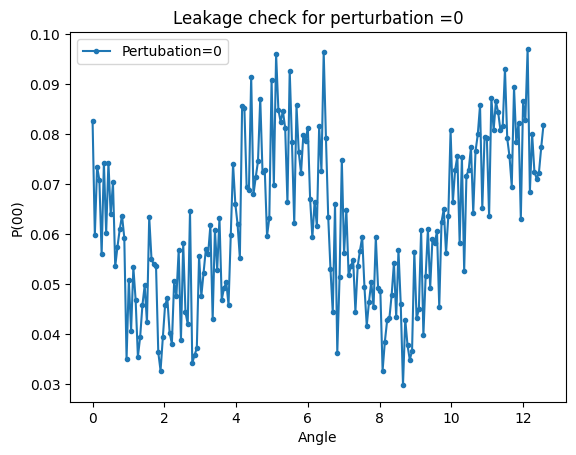

In [48]:
import matplotlib.pyplot as plt

job = service.job('crbh50wdqdn000832vd0')


Result = job.result()


R = [Result.quasi_dists[i][0] for i in range(200)]
plt.plot(np.linspace(0,4*np.pi,200),R, ".-",label = "Pertubation=0")
plt.xlabel("Angle")
plt.ylabel("P(00)")
plt.legend()
plt.title("Leakage check for perturbation =0")
plt.savefig("BP_qck_t"+str(0)+".png")
plt.show()

In [49]:
max(R)- min(R)

0.06722544078741657

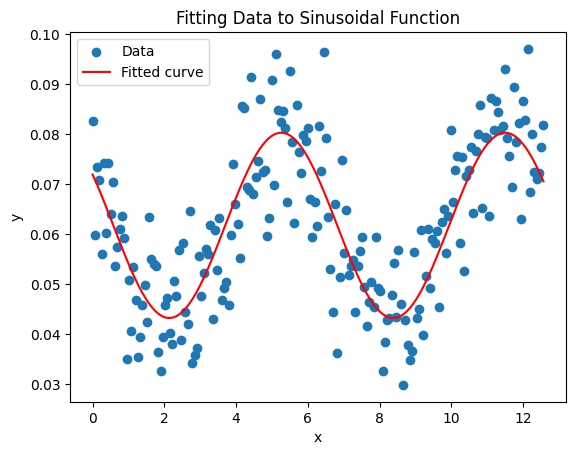

Optimized parameters:
Amplitude: -0.018536351976231585
Frequency: 1.0068188686779838
Phase: -0.5811444935602034
Offset: 0.06174952279228838
10.867840626359984


In [50]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sinusoidal function
def sinusoidal_func(x, A, f, phi, offset):
    return A * np.sin(f * x + phi) + offset



# Fit the data to the sinusoidal function
initial_guess = (3, 1, np.pi/4, 1)  # initial guess for the parameters (A, f, phi, offset)
popt, pcov = curve_fit(sinusoidal_func, np.linspace(0,4*np.pi,200), R, p0=initial_guess)

# Plot the original data and the fitted curve
plt.scatter(np.linspace(0,4*np.pi,200), R, label='Data')
plt.plot(np.linspace(0,4*np.pi,200), sinusoidal_func(np.linspace(0,4*np.pi,200), *popt), 'r-', label='Fitted curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Fitting Data to Sinusoidal Function')
plt.show()

# Print the optimized parameters
print("Optimized parameters:")
print("Amplitude:", popt[0])
print("Frequency:", popt[1])
print("Phase:", popt[2])
print("Offset:", popt[3])

E = sum(np.abs(R-sinusoidal_func(np.linspace(0,4*np.pi,200),*popt)))/200
print(100*E/0.06722544078741657)

In [59]:
[100*np.sqrt(np.diag(pcov))[i]/popt[i] for i in range(4)]

[-4.950248545916402,
 1.3563894131582557,
 -16.168853628223413,
 1.0653861702489746]

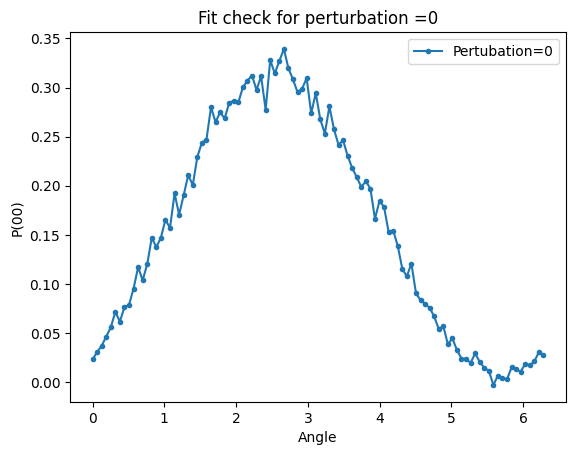

In [60]:
import matplotlib.pyplot as plt

job = service.job('crb3b5mbs5wg008anxjg')


Result = job.result()


R = [Result.quasi_dists[i][0] for i in range(100)]
plt.plot(np.linspace(0,2*np.pi,100),R, ".-",label = "Pertubation=0")
plt.xlabel("Angle")
plt.ylabel("P(00)")
plt.legend()
plt.title("Fit check for perturbation =0")
# plt.savefig("BP_qck_t"+str(0)+".png")
plt.show()

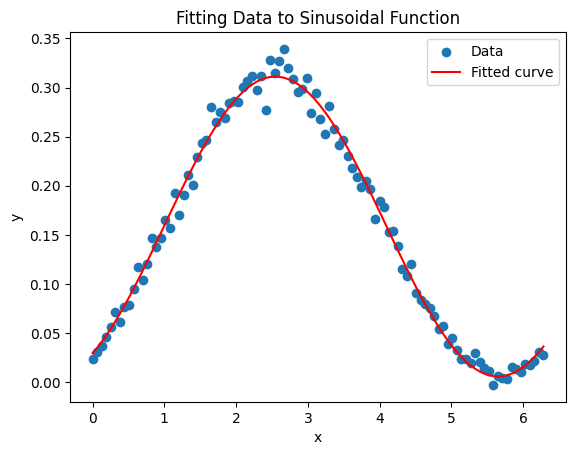

Optimized parameters:
Amplitude: -0.1526384140581808
Frequency: 1.0123671778612433
Phase: 2.1354435557591747
Offset: 0.15850280759067412
1.0380025379940303


In [64]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sinusoidal function
def sinusoidal_func(x, A, f, phi, offset):
    return A * np.sin(f * x + phi) + offset



# Fit the data to the sinusoidal function
initial_guess = (1, 1, np.pi/4, 0)  # initial guess for the parameters (A, f, phi, offset)
popt, pcov = curve_fit(sinusoidal_func, np.linspace(0,2*np.pi,100), R, p0=initial_guess)

# Plot the original data and the fitted curve
plt.scatter(np.linspace(0,2*np.pi,100), R, label='Data')
plt.plot(np.linspace(0,2*np.pi,100), sinusoidal_func(np.linspace(0,2*np.pi,100), *popt), 'r-', label='Fitted curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Fitting Data to Sinusoidal Function')
plt.show()

# Print the optimized parameters
print("Optimized parameters:")
print("Amplitude:", popt[0])
print("Frequency:", popt[1])
print("Phase:", popt[2])
print("Offset:", popt[3])

print(100*np.sqrt(np.diag(pcov))[2]/popt[2])

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sinusoidal function
def sinusoidal_func(x, A, f, phi, offset):
    return A * np.sin(f * x + phi) + offset



# Fit the data to the sinusoidal function
initial_guess = (1, 1, np.pi/4, 0)  # initial guess for the parameters (A, f, phi, offset)
popt, pcov = curve_fit(sinusoidal_func, np.linspace(0,2*np.pi,100), R, p0=initial_guess)

# Plot the original data and the fitted curve
plt.scatter(np.linspace(0,2*np.pi,100), R, label='Data')
plt.plot(np.linspace(0,2*np.pi,100), sinusoidal_func(np.linspace(0,2*np.pi,100), *popt), 'r-', label='Fitted curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Fitting Data to Sinusoidal Function')
plt.show()

# Print the optimized parameters
print("Optimized parameters:")
print("Amplitude:", popt[0])
print("Frequency:", popt[1])
print("Phase:", popt[2])
print("Offset:", popt[3])

print(np.sqrt(np.diag(pcov))[2]/popt[2])